# Validating A/B Test Results

<img src="https://www.apptentive.com/wp-content/uploads/2016/01/ab-testing.png" alt="AB" title="AB" />
## Introduction

Yammer not only develops new features, but is continuously looking for ways to improving existing ones. Like many software companies, Yammer frequently tests these features before releasing them to all of thier customers. These A/B tests help analysts and product managers better understand a feature’s effect on user behavior and the overall user experience.

This case focuses on an improvement to Yammer’s core “publisher”—the module at the top of a Yammer feed where users type their messages. To test this feature, the product team ran an A/B test from June 1 through June 30. During this period, some users who logged into Yammer were shown the old version of the publisher (the “control group”), while other other users were shown the new version (the “treatment group”). In this report, the performance of each group across various metrics will be compared to determine whether the update produced a change in user behavior. Then, there will be an investigation into a possible factor that could give insight into any possible confounds within the initial test.

This repository also contains visualizations made in Tableau. If you do not have Tableau installed, you may access these visualizations through Tableau Reader: a free companion program for Tableau Desktop.

# Notebook Contents
## Part I : Examining Initial Results
## Part II: Investigating User Treatment
## Part III: Discussion of Results
<br>
# Part I: Examining Initial Results
The first metric to test the update's efficacy is to examine if there is a difference in the average messages sent per user between the two test groups, and, if a difference exists, if that difference is significant.
## Metric Testing I: Average Messages Sent

In [26]:
import pandas as pd
import numpy as np
from scipy import stats
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3

DB = 'yammer.db'

def run_query(q):
    with sqlite3.connect(DB) as conn:
        return pd.read_sql(q,conn)

def run_command(c):
    with sqlite3.connect(DB) as conn:
        conn.execute('PRAGMA foreign_keys = ON;')
        conn.isolation_level = None
        conn.execute(c)

def show_tables():
    q = '''
    SELECT
        name,
        type
    FROM sqlite_master
    WHERE type IN ("table","view");
    '''
    return run_query(q)

show_tables()

,name,type
0,y_users,table
1,y_experiments,table
2,y_events,table
3,y_emails,table


In [13]:
# events_sorted 
# query events from experiment users filtered by dates experiment is active
# refer to Yammer DB workbook for database construction

q_event = """
    SELECT 
        ev.user_id, 
        ev.occurred_at, 
        ev.event_type, 
        ev.event_name
    FROM y_experiments ex
    INNER JOIN y_events ev
    ON ex.user_id = ev.user_id
    WHERE ev.occurred_at <= '2014-07-01' AND ex.occurred_at >= '2014-06-01'
    ORDER BY ev.occurred_at DESC

"""
events_sorted = run_query(q_event)
events_sorted.head()

,user_id,occurred_at,event_type,event_name
0,14893,2014-06-30 23:47:04,engagement,like_message
1,14893,2014-06-30 23:46:40,engagement,home_page
2,14893,2014-06-30 23:46:10,engagement,send_message
3,14893,2014-06-30 23:45:43,engagement,like_message
4,14893,2014-06-30 23:45:14,engagement,view_inbox


In [14]:
q_tags = """
    SELECT user_id, experiment_group
    FROM y_experiments;
    """
ex_tags = run_query(q_tags)
ex_tags.head()

,user_id,experiment_group
0,4,control_group
1,11,control_group
2,19,test_group
3,20,control_group
4,22,test_group


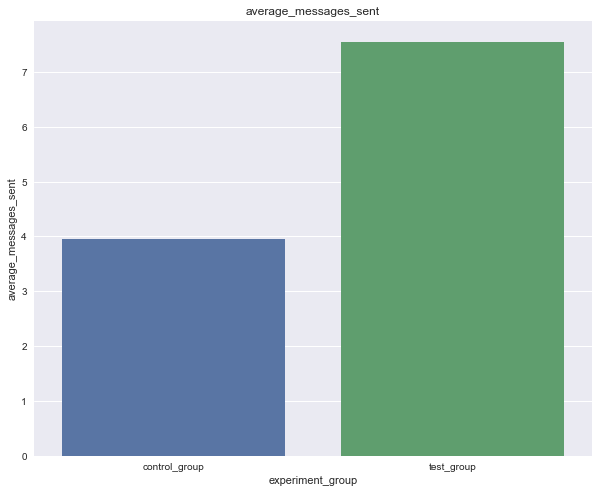

,experiment,experiment_group,users_per_group,total_treated_users,treatment_percent,total_msgs_sent,average_messages_sent,rate_difference,rate_lift,std_dev,t_stat,p_value
0,publisher_update,control_group,1746,2595,0.672832,6919.0,3.962772,0.000000,0.000000,5.555127,0.000000,1.000000e+00
1,publisher_update,test_group,849,2595,0.327168,6415.0,7.555948,3.593176,0.906733,8.041822,11.722932,3.427774e-30


In [18]:
dfc = events_sorted.groupby('user_id')['event_name'].value_counts()
dfc2 = pd.DataFrame(dfc)
dfc2.columns = ['frequency']
dfc3 = dfc2.unstack(level=1)

def abtest(metric, graph_title_avg):
    dfc4= dfc3[[('frequency', metric)]]

    # dfc4 contains the total messages sent per user between event period
    dfc4.columns = [metric]
    dfc4 = dfc4.reset_index()

    # ex_tags contains user_id and experiment group info 
    # left merge because some users assigned in experiment did not interact within the experiment period
    dfc5 = ex_tags.merge(dfc4, how='left', on='user_id').fillna(0)

    #t-test
    controldf = dfc5[dfc5.experiment_group == 'control_group']
    testdf = dfc5[dfc5.experiment_group == 'test_group']
    t_test = stats.ttest_ind(testdf[metric], controldf[metric], equal_var=False)


    #ab test summary for messages sent between control and test group
    d = {'experiment': ['publisher_update', 'publisher_update'], 'experiment_group': ['control_group', 'test_group'],\
    'users_per_group': [len(controldf.index),len(testdf.index)], 'total_treated_users': [len(dfc5.index),len(dfc5.index)],\
     'treatment_percent': [len(controldf.index)*1.0/len(dfc5.index), len(testdf.index)*1.0/len(dfc5.index)],\
     'total_msgs_sent': [controldf[metric].sum(),testdf[metric].sum()],\
     graph_title_avg:[controldf[metric].mean(),testdf[metric].mean()],\
     'rate_difference': [controldf[metric].mean()-controldf[metric].mean(),testdf[metric].mean()-controldf[metric].mean()],\
     'rate_lift': [controldf[metric].mean()/controldf[metric].mean() - 1, testdf[metric].mean()/controldf[metric].mean() - 1],\
     'std_dev': [np.std(controldf[metric]),np.std(testdf[metric])],
     't_stat': [0,t_test.statistic], 'p_value': [1-t_test.pvalue,t_test.pvalue]
    }

    summary = pd.DataFrame(d, columns=d)
    ax = sns.barplot(x="experiment_group", y=graph_title_avg, data=summary)
    ax.set_title(graph_title_avg)
    sns.set(rc={'figure.figsize':(10,8)})
    plt.show()
    return summary
    
abtest('send_message','average_messages_sent')

## Metric Testing I: Average Logins
Users in the group receiving the update appear to be significantly sending more messages. However, the effectiveness of the new update should not only be limited to one metric. In the next cell, there will be an examination of logins across the experiment groups. 

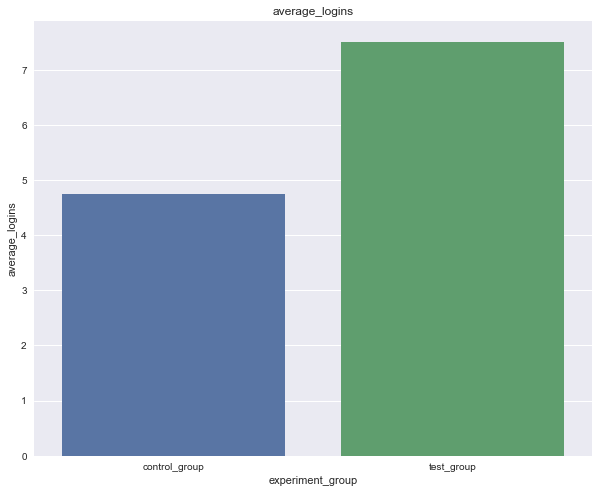

,experiment,experiment_group,users_per_group,total_treated_users,treatment_percent,total_msgs_sent,average_logins,rate_difference,rate_lift,std_dev,t_stat,p_value
0,publisher_update,control_group,1746,2595,0.672832,8288.0,4.74685,0.00000,0.000000,4.191992,0.000000,1.000000e+00
1,publisher_update,test_group,849,2595,0.327168,6377.0,7.51119,2.76434,0.582352,5.528611,12.872769,7.810399e-36


In [20]:
def abtest(metric, graph_title_avg):
    dfc4= dfc3[[('frequency', metric)]]

    # dfc4 contains the total messages sent per user between event period
    dfc4.columns = [metric]
    dfc4 = dfc4.reset_index()

    # ex_tags contains user_id and experiment group info 
    # left merge because some users assigned in experiment did not interact within the experiment period
    dfc5 = ex_tags.merge(dfc4, how='left', on='user_id').fillna(0)

    #t-test
    controldf = dfc5[dfc5.experiment_group == 'control_group']
    testdf = dfc5[dfc5.experiment_group == 'test_group']
    t_test = stats.ttest_ind(testdf[metric], controldf[metric], equal_var=False)


    #ab test summary for messages sent between control and test group
    d = {'experiment': ['publisher_update', 'publisher_update'], 'experiment_group': ['control_group', 'test_group'],\
    'users_per_group': [len(controldf.index),len(testdf.index)], 'total_treated_users': [len(dfc5.index),len(dfc5.index)],\
     'treatment_percent': [len(controldf.index)*1.0/len(dfc5.index), len(testdf.index)*1.0/len(dfc5.index)],\
     'total_msgs_sent': [controldf[metric].sum(),testdf[metric].sum()],\
     graph_title_avg:[controldf[metric].mean(),testdf[metric].mean()],\
     'rate_difference': [controldf[metric].mean()-controldf[metric].mean(),testdf[metric].mean()-controldf[metric].mean()],\
     'rate_lift': [controldf[metric].mean()/controldf[metric].mean() - 1, testdf[metric].mean()/controldf[metric].mean() - 1],\
     'std_dev': [np.std(controldf[metric]),np.std(testdf[metric])],
     't_stat': [0,t_test.statistic], 'p_value': [1-t_test.pvalue,t_test.pvalue]
    }

    summary = pd.DataFrame(d, columns=d)
    ax = sns.barplot(x="experiment_group", y=graph_title_avg, data=summary)
    ax.set_title(graph_title_avg)
    sns.set(rc={'figure.figsize':(10,8)})
    plt.show()
    return summary
    
abtest('login','average_logins')

## Metric Testing I: Average Days Engaged
Users are logging into Yammer more frequently too after experiencing the update. In the attached Tableau visualization, other metrics, such as use of Yammer's search engine, are noted with a marked increase. The next cell will also provide some insight into any differences in engagement (days engaged the distinct number of days customers use Yammer) that might exist between the groups.

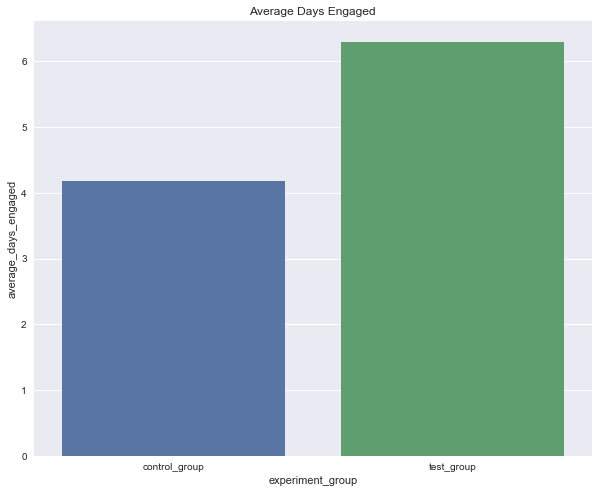

,experiment,experiment_group,users_per_group,total_treated_users,treatment_percent,total_days_engaged,average_days_engaged,rate_difference,rate_lift,std_dev,t_stat,p_value
0,publisher_update,control_group,1746,2595,0.672832,7292,4.176403,0.00000,0.00000,3.23158,0.000000,1.000000e+00
1,publisher_update,test_group,849,2595,0.327168,5349,6.300353,2.12395,0.50856,4.00271,13.465914,5.853088e-39


In [87]:
df = events_sorted
df['occurred_at'] = pd.to_datetime(df['occurred_at'])
df = df.sort_values(['user_id','occurred_at'])
df = df[df.event_type == 'engagement']
dfc = df.groupby(['user_id', df.occurred_at.dt.day])['occurred_at'].nunique()

# dfc0: number of interactions by user and date
dfc0 = dfc.groupby(level=[0]).size()
dfc0 = dfc0.reset_index()
dfc0.columns = ['user_id','frequency']

# ex_tags contains user_id and experiment group info 
# left merge because some users assigned in experiment did not interact within the experiment period
dfc5 = ex_tags.merge(dfc0, how='left', on='user_id').fillna(0)

#t-test groups and perform
controldf = dfc5[dfc5.experiment_group == 'control_group']
testdf = dfc5[dfc5.experiment_group == 'test_group']
t_test = stats.ttest_ind(testdf['frequency'], controldf['frequency'], equal_var=False)

#summary df
d = {'experiment': ['publisher_update', 'publisher_update'], 'experiment_group': ['control_group', 'test_group'],\
    'users_per_group': [len(controldf.index),len(testdf.index)], 'total_treated_users': [len(dfc5.index),len(dfc5.index)],\
     'treatment_percent': [len(controldf.index)*1.0/len(dfc5.index), len(testdf.index)*1.0/len(dfc5.index)],\
     'total_days_engaged': [controldf['frequency'].sum(),testdf['frequency'].sum()],\
     'average_days_engaged':[controldf['frequency'].mean(),testdf['frequency'].mean()],\
     'rate_difference': [controldf['frequency'].mean()-controldf['frequency'].mean(),testdf['frequency'].mean()-controldf['frequency'].mean()],\
     'rate_lift': [controldf['frequency'].mean()/controldf['frequency'].mean() - 1, testdf['frequency'].mean()/controldf['frequency'].mean() - 1],\
     'std_dev': [np.std(controldf['frequency']),np.std(testdf['frequency'])],
     't_stat': [0,t_test.statistic], 'p_value': [1-t_test.pvalue,t_test.pvalue]
    }

summary = pd.DataFrame(d, columns=d)

ax = sns.barplot(x="experiment_group", y="average_days_engaged", data=summary)
ax.set_title('Average Days Engaged')
sns.set(rc={'figure.figsize':(10,8)})
plt.show()

summary

Engagement is also more frequent among members of the test group. It appears that examining the results of different metrics will not dispute the test group's increased performance after the update. However, it is possible that there may be inherent differences within the experiment groups that could explain why the test group has performed better than the control group.

# Part II: Investigating User Treatment
### Were members randomly divided into control and test groups?
One of the pieces in the Yammer dataset includes information on when its users activated their accounts. The following cell will investigate the quantities of when users in both experiment activated their accounts, to see if there is a difference in acccount age between the groups.

In [55]:
# query data when users in experiment activated their account

q_act = """
    SELECT 
        u.user_id, 
        u.activated_at, 
        e.experiment_group
    FROM y_users u
    JOIN y_experiments e
    ON u.user_id = e.user_id
    ORDER BY u.activated_at;
    """
act = run_query(q_act)
act.head()

,user_id,activated_at,experiment_group
0,11,2013-01-01 08:09:17,control_group
1,4,2013-01-01 14:39:05,control_group
2,20,2013-01-02 09:43:26,control_group
3,19,2013-01-02 09:55:34,test_group
4,22,2013-01-02 17:38:09,test_group


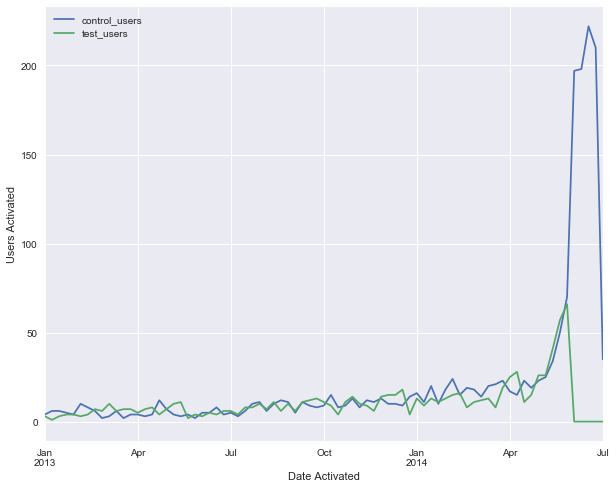

In [88]:
act['activated_at'] = pd.to_datetime(act['activated_at'])
df = act.set_index('activated_at')

df_test = df[df.experiment_group == 'test_group']
df_control = df[df.experiment_group == 'control_group']

df_test2 = df_test.resample('W').agg({"user_id": 'count'})
df_control2 = df_control.resample('W').agg({"user_id": 'count'})

df_test2.columns = ['test_users']
df_control2.columns = ['control_users']
df_test2  = df_test2.reset_index()
df_control2  = df_control2.reset_index()
df_all = df_control2.merge(df_test2, how='left', on='activated_at').fillna(0)
df_all['activated_at'] =  pd.to_datetime(df_all['activated_at'])
df_all = df_all.set_index('activated_at')

df_all.plot()
plt.ylabel('Users Activated')
plt.xlabel('Date Activated')
sns.set(rc={'figure.figsize':(10,8)})
plt.show()


Users in the test/update group activate their accounts no later than in the first week in June, whereas there are several in the control group that continue to activate their account, even during the duration of the study. For this reason, it is worthwhile to filter out new users that have activated their account during the testing period, as they have not had as long of a time to engage in Yammer's services compared to existing users. The next two cells will investigate the previous metrics between existing users in both groups for differences in performance. Other metrics are also available on the tableau visualization.

## Metric Testing II: Average Messages Sent Among Existing Users

In [22]:
# query data when users in experiment activated their account
q_existing_u = """
    SELECT 
        u.user_id, 
        u.activated_at, 
        e.experiment_group
    FROM y_users u
    JOIN y_experiments e
    ON u.user_id = e.user_id
    WHERE u.activated_at <= '2014-06-01'
    ORDER BY u.activated_at
;
    """
existing_user = run_query(q_existing_u)
existing_user.head()

,user_id,activated_at,experiment_group
0,11,2013-01-01 08:09:17,control_group
1,4,2013-01-01 14:39:05,control_group
2,20,2013-01-02 09:43:26,control_group
3,19,2013-01-02 09:55:34,test_group
4,22,2013-01-02 17:38:09,test_group


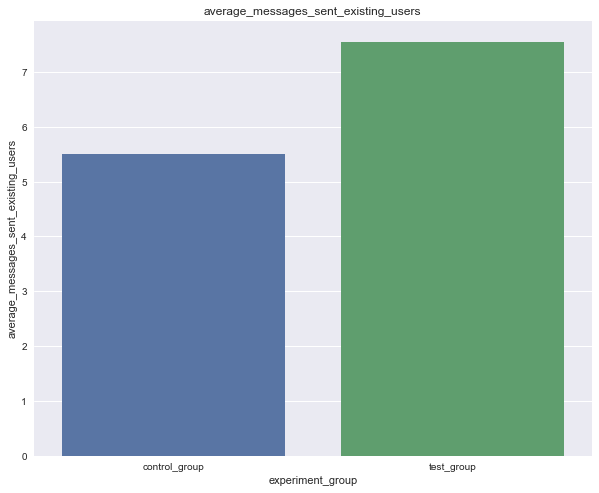

,experiment,experiment_group,users_per_group,total_treated_users,treatment_percent,total_msgs_sent,average_messages_sent_existing_users,rate_difference,rate_lift,std_dev,t_stat,p_value
0,publisher_update,control_group,873,1722,0.506969,4805.0,5.504009,0.000000,0.000000,6.839699,0.000000,1.000000e+00
1,publisher_update,test_group,849,1722,0.493031,6415.0,7.555948,2.051939,0.372808,8.041822,5.692996,1.473094e-08


In [24]:
def abtest_existing_user(metric, graph_title_avg):
    dfc4= dfc3[[('frequency', metric)]]

    # dfc4 contains the total messages sent per user between event period
    dfc4.columns = [metric]
    dfc4 = dfc4.reset_index()

    # ex_tags contains user_id and experiment group info 
    # left merge because some users assigned in experiment did not interact within the experiment period
    dfc5 = existing_user.merge(dfc4, how='left', on='user_id').fillna(0)

    #t-test
    controldf = dfc5[dfc5.experiment_group == 'control_group']
    testdf = dfc5[dfc5.experiment_group == 'test_group']
    t_test = stats.ttest_ind(testdf[metric], controldf[metric], equal_var=False)


    #ab test summary for messages sent between control and test group
    d = {'experiment': ['publisher_update', 'publisher_update'], 'experiment_group': ['control_group', 'test_group'],\
    'users_per_group': [len(controldf.index),len(testdf.index)], 'total_treated_users': [len(dfc5.index),len(dfc5.index)],\
     'treatment_percent': [len(controldf.index)*1.0/len(dfc5.index), len(testdf.index)*1.0/len(dfc5.index)],\
     'total_msgs_sent': [controldf[metric].sum(),testdf[metric].sum()],\
     graph_title_avg:[controldf[metric].mean(),testdf[metric].mean()],\
     'rate_difference': [controldf[metric].mean()-controldf[metric].mean(),testdf[metric].mean()-controldf[metric].mean()],\
     'rate_lift': [controldf[metric].mean()/controldf[metric].mean() - 1, testdf[metric].mean()/controldf[metric].mean() - 1],\
     'std_dev': [np.std(controldf[metric]),np.std(testdf[metric])],
     't_stat': [0,t_test.statistic], 'p_value': [1-t_test.pvalue,t_test.pvalue]
    }

    summary = pd.DataFrame(d, columns=d)
    ax = sns.barplot(x="experiment_group", y=graph_title_avg, data=summary)
    ax.set_title(graph_title_avg)
    sns.set(rc={'figure.figsize':(10,8)})
    plt.show()
    return summary
    
abtest_existing_user('send_message','average_messages_sent_existing_users')

## Metric Testing II: Average Logins Among Existing Users

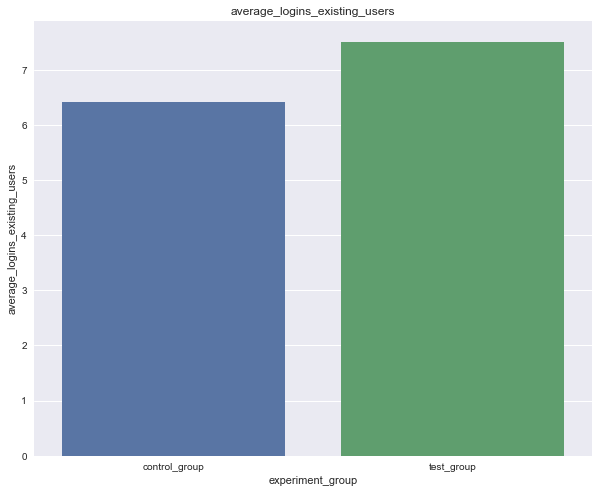

,experiment,experiment_group,users_per_group,total_treated_users,treatment_percent,total_msgs_sent,average_logins_existing_users,rate_difference,rate_lift,std_dev,t_stat,p_value
0,publisher_update,control_group,873,1722,0.506969,5601.0,6.415808,0.000000,0.000000,4.946224,0.000000,0.999984
1,publisher_update,test_group,849,1722,0.493031,6377.0,7.511190,1.095382,0.170732,5.528611,4.326478,0.000016


In [25]:
def abtest_existing_user(metric, graph_title_avg):
    dfc4= dfc3[[('frequency', metric)]]

    # dfc4 contains the total messages sent per user between event period
    dfc4.columns = [metric]
    dfc4 = dfc4.reset_index()

    # ex_tags contains user_id and experiment group info 
    # left merge because some users assigned in experiment did not interact within the experiment period
    dfc5 = existing_user.merge(dfc4, how='left', on='user_id').fillna(0)

    #t-test
    controldf = dfc5[dfc5.experiment_group == 'control_group']
    testdf = dfc5[dfc5.experiment_group == 'test_group']
    t_test = stats.ttest_ind(testdf[metric], controldf[metric], equal_var=False)


    #ab test summary for messages sent between control and test group
    d = {'experiment': ['publisher_update', 'publisher_update'], 'experiment_group': ['control_group', 'test_group'],\
    'users_per_group': [len(controldf.index),len(testdf.index)], 'total_treated_users': [len(dfc5.index),len(dfc5.index)],\
     'treatment_percent': [len(controldf.index)*1.0/len(dfc5.index), len(testdf.index)*1.0/len(dfc5.index)],\
     'total_msgs_sent': [controldf[metric].sum(),testdf[metric].sum()],\
     graph_title_avg:[controldf[metric].mean(),testdf[metric].mean()],\
     'rate_difference': [controldf[metric].mean()-controldf[metric].mean(),testdf[metric].mean()-controldf[metric].mean()],\
     'rate_lift': [controldf[metric].mean()/controldf[metric].mean() - 1, testdf[metric].mean()/controldf[metric].mean() - 1],\
     'std_dev': [np.std(controldf[metric]),np.std(testdf[metric])],
     't_stat': [0,t_test.statistic], 'p_value': [1-t_test.pvalue,t_test.pvalue]
    }

    summary = pd.DataFrame(d, columns=d)
    ax = sns.barplot(x="experiment_group", y=graph_title_avg, data=summary)
    ax.set_title(graph_title_avg)
    sns.set(rc={'figure.figsize':(10,8)})
    plt.show()
    return summary
    
abtest_existing_user('login','average_logins_existing_users')

# Part III: Discussion of Results
Tested among several measures, it does appear that the new update is correlated with an increase of user activity. The experiment groups, however, were not separated randomly, as the test group who got the update consisted of users who activated their accounts before the experiment period began, whereas the control group consisted of mostly new users who activated their accounts after the experiment began. After filtering out users that activated their accounts after the experiment began, metric testing still suggests that users who experienced the new update tended to interact on Yammer more than the control group. I have summarized each step of metric testing before filtering new users and after filtering for new users in the attached Tableau workbook. The workbook also details other metrics that the analyst group may be interested in that were not covered in this juptyer notebook.